In [4]:
import pandas as pd

results_5R = pd.read_pickle('results_5R.pickle')
horse_results = pd.read_pickle('horse_data.pickle')
return_tables = pd.read_pickle('return_tables.pickle')
peds = pd.read_pickle('peds.pickle')

In [18]:
results_5R.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43239 entries, 202001010101 to 202010010412
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   着順            43239 non-null  int32         
 1   枠番            43239 non-null  int64         
 2   馬番            43239 non-null  int64         
 3   馬名            43239 non-null  object        
 4   斤量            43239 non-null  float64       
 5   騎手            43239 non-null  object        
 6   単勝            43239 non-null  float64       
 7   人気            43239 non-null  float64       
 8   horse_id      43239 non-null  object        
 9   jockey_id     43239 non-null  object        
 10  性             43239 non-null  object        
 11  齢             43239 non-null  int32         
 12  体重            43239 non-null  int32         
 13  体重増減          43239 non-null  int32         
 14  course_len    43239 non-null  object        
 15  weather       43239 non

In [15]:
results_m = results_5R.merge(peds, left_on='horse_id', right_index=True, how='left')
results_m.drop(['馬名','騎手'], axis=1,inplace=True)

In [8]:
from sklearn.preprocessing import LabelEncoder

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
        
    df2 = pd.get_dummies(df2)
    
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

In [16]:
categorical_columns = ['horse_id']+['peds_{}'.format(i) for i in range(62)]
results_d = process_categorical(results_m, categorical_columns)

In [19]:
results_d["rank"] = results_5R["着順"].map(lambda x:1 if x <4 else 0)
results_d.drop(["着順","人気","単勝"],axis=1, inplace=True)

In [20]:
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    train.drop(['date'],axis=1,inplace=True)
    test.drop(['date'],axis=1,inplace=True)
    return train, test

train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [24]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score

params = {
    'num_leaves':3, #デフォルトは34
    'n_estimators':70,
    'min_data_in_leaf':300,
    'class_weight':'balanced',
    'random_state':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) #値に日本語が入っているとエラー

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


LGBMClassifier(class_weight='balanced', min_data_in_leaf=300, n_estimators=70,
               num_leaves=3, random_state=100)

In [21]:
class ModelEvaluator:
    def __init__(self, model, return_table):
        self.model = model
        self.fuku = Return(return_table).fuku
        self.tan = Return(return_table).tan
        
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:,1]
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def fuku_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def tan_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.tan.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
       
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money

In [22]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
        
    #複勝行の加工 
    @property
    def fuku(self):
        fuku = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        #勝ち馬の馬番
        wins = fuku[1].str.split('br', expand = True).drop([3,4], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        #払い戻し
        returns = fuku[2].str.split('br', expand = True).drop([3,4], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    
    @property
    def tan(self):
        tan = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tan.columns = ['win', 'return']
        
        for column in tan.columns:
            tan[column] = pd.to_numeric(tan[column], errors='coerce')
        return tan

In [25]:
me = ModelEvaluator(lgb_clf, return_tables)
me.predict_proba(X_test)

array([0.63859213, 0.62145211, 0.54008874, ..., 0.43572901, 0.64329954,
       0.46284905])

In [26]:
proba_table = X_test[['horse_id']].copy()
proba_table['proba'] = me.predict_proba(X_test)
proba_table

,horse_id,proba
202001020703,6788,0.638592
202001020703,7634,0.621452
202001020703,7141,0.540089
202001020703,6728,0.635257
202001020703,5918,0.607049
...,...,...
202006050807,5083,0.599909
202006050807,3153,0.399495
202006050807,4927,0.435729
202006050807,7496,0.643300


In [27]:
proba_table['R'] = proba_table.index.map(lambda x:str(x)[-2:] )
proba_table

,horse_id,proba,R
202001020703,6788,0.638592,03
202001020703,7634,0.621452,03
202001020703,7141,0.540089,03
202001020703,6728,0.635257,03
202001020703,5918,0.607049,03
...,...,...,...
202006050807,5083,0.599909,07
202006050807,3153,0.399495,07
202006050807,4927,0.435729,07
202006050807,7496,0.643300,07


In [32]:
proba_table[proba_table.index=='202001020712']['proba']

202001020712    0.723945
202001020712    0.438068
202001020712    0.546473
202001020712    0.542867
202001020712    0.648654
202001020712    0.575452
202001020712    0.488532
202001020712    0.443360
202001020712    0.486070
202001020712    0.555755
202001020712    0.425145
202001020712    0.571681
202001020712    0.550946
202001020712    0.509932
Name: proba, dtype: float64

In [28]:
proba_table.groupby('R')['proba'].mean() #ラウンドによって的中確率の平均が違うのに、一律のthresholdによって掛ける馬を決めている

R
01    0.415002
02    0.438666
03    0.462250
04    0.481936
05    0.501211
06    0.522731
07    0.534193
08    0.543168
09    0.573200
10    0.546986
11    0.556580
12    0.543674
Name: proba, dtype: float64

In [35]:
import numpy as np
#標準化 X→(X-μ)/σ
standard_scaler = lambda x: (x-x.mean())/x.std()
proba_std = proba_table.groupby(level=0)['proba'].transform(standard_scaler)

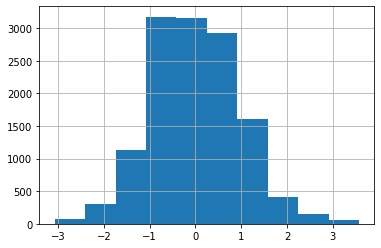

In [36]:
proba_std.hist()

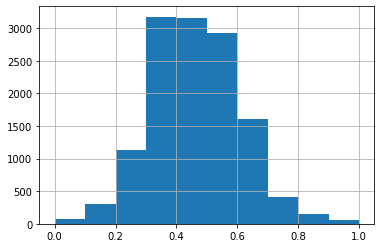

In [37]:
#MinMaxスケーリング：データを0から1までの値にする
proba_minmax = (proba_std - proba_std.min())/(proba_std.max() - proba_std.min())
proba_minmax.hist()

In [104]:
#実装
class ModelEvaluator:
    def __init__(self, model, return_table, std=True):
        self.model = model
        self.fuku = Return(return_table).fuku
        self.tan = Return(return_table).tan
        self.std = std ###
        
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x-x.mean())/x.std()
            proba = proba.groupby(level=0).transform(standard_scaler) #標準化
            proba = (proba - proba.min())/(proba.max() - proba.min()) #MinMaxスケーリング
        return proba
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
        
    def fuku_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def tan_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.tan.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
       
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money

In [111]:
from tqdm.notebook import tqdm_notebook as tqdm

def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5): #threshold0.5から1までを１００等分
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = i/n_samples +min_threshold*(1-i/n_samples)
        n_bets, money =return_func(X, threshold)
        if n_bets>lower:
            gain[n_bets] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [56]:
gain_std = gain(me.tan_return, X_test)

In [58]:
me = ModelEvaluator(lgb_clf, return_tables, False)
gain = gain(me.tan_return, X_test)

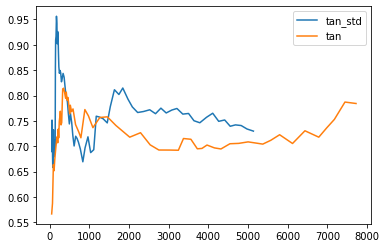

In [59]:
gain_std.rename('tan_std').plot(legend=True)
gain.rename('tan').plot(legend=True)

In [114]:
me = ModelEvaluator(lgb_clf, return_tables, True)
fuku_std = gain(me.fuku_return, X_test)

In [115]:
me = ModelEvaluator(lgb_clf, return_tables, False)
fuku = gain(me.fuku_return, X_test)

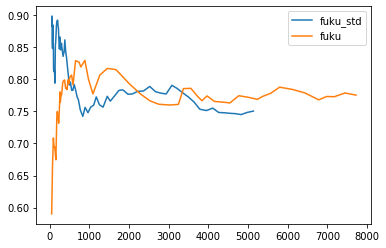

In [116]:
fuku_std.rename('fuku_std').plot(legend=True)
fuku.rename('fuku').plot(legend=True)